In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive/PCB_DATASET'

Mounted at /content/drive


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 50.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Explore Dataset

In [ ]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

In [ ]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [ ]:
import os

dataset_dir = '/content/drive/MyDrive/PCB_DATASET'

# Check the folders in images and annotations
images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

# List all folders and subfolders
print("Images Directory Contents:")
print(os.listdir(images_dir))  # This will show all the subfolders (like 'Missing_hole', etc.)

print("\nAnnotations Directory Contents:")
print(os.listdir(annot_dir))  # This will show all the subfolders (like 'Missing_hole', etc.)


Images Directory Contents:
['Open_circuit', 'Short', 'Spurious_copper', 'Spur', 'Missing_hole', 'Mouse_bite']

Annotations Directory Contents:
['Missing_hole', 'Spur', 'Open_circuit', 'Spurious_copper', 'Mouse_bite', 'Short']


In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

# List all subfolders
for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    # Print the full path to check if they are correct
    print(f"Checking subfolder: {subfolder}")
    print(f"Images path: {images_path}")
    print(f"Annotations path: {annot_path}")

    # Check if both paths exist
    if not os.path.exists(images_path):
        print(f"Error: {images_path} does not exist!")
    if not os.path.exists(annot_path):
        print(f"Error: {annot_path} does not exist!")

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')


Checking subfolder: Missing_hole
Images path: /content/drive/MyDrive/PCB_DATASET/images/Missing_hole
Annotations path: /content/drive/MyDrive/PCB_DATASET/Annotations/Missing_hole
Missing_hole    	            115 images 	            115 annotations
Checking subfolder: Mouse_bite
Images path: /content/drive/MyDrive/PCB_DATASET/images/Mouse_bite
Annotations path: /content/drive/MyDrive/PCB_DATASET/Annotations/Mouse_bite
Mouse_bite      	            115 images 	            115 annotations
Checking subfolder: Open_circuit
Images path: /content/drive/MyDrive/PCB_DATASET/images/Open_circuit
Annotations path: /content/drive/MyDrive/PCB_DATASET/Annotations/Open_circuit
Open_circuit    	            116 images 	            116 annotations
Checking subfolder: Short
Images path: /content/drive/MyDrive/PCB_DATASET/images/Short
Annotations path: /content/drive/MyDrive/PCB_DATASET/Annotations/Short
Short           	            116 images 	            116 annotations
Checking subfolder: Spur
Images pat

In [ ]:
images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'Checking paths: {images_path} and {annot_path}')
    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')


Checking paths: /content/drive/MyDrive/PCB_DATASET/images/Missing_hole and /content/drive/MyDrive/PCB_DATASET/Annotations/Missing_hole
Missing_hole    	            115 images 	            115 annotations
Checking paths: /content/drive/MyDrive/PCB_DATASET/images/Mouse_bite and /content/drive/MyDrive/PCB_DATASET/Annotations/Mouse_bite
Mouse_bite      	            115 images 	            115 annotations
Checking paths: /content/drive/MyDrive/PCB_DATASET/images/Open_circuit and /content/drive/MyDrive/PCB_DATASET/Annotations/Open_circuit
Open_circuit    	            116 images 	            116 annotations
Checking paths: /content/drive/MyDrive/PCB_DATASET/images/Short and /content/drive/MyDrive/PCB_DATASET/Annotations/Short
Short           	            116 images 	            116 annotations
Checking paths: /content/drive/MyDrive/PCB_DATASET/images/Spur and /content/drive/MyDrive/PCB_DATASET/Annotations/Spur
Spur            	            115 images 	            115 annotations
Checking paths

# Create annotaton dataset

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [ ]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_missing_hole_07.jpg   3034    1586  missing_hole  1737   340  1793   394
1  01_missing_hole_07.jpg   3034    1586  missing_hole  1390  1042  1470  1122
2  01_missing_hole_07.jpg   3034    1586  missing_hole  2580   238  2648   294
3  01_missing_hole_03.jpg   3034    1586  missing_hole  2651   487  2700   531
4  01_missing_hole_03.jpg   3034    1586  missing_hole  1342   749  1393   796

\\# Visualization

In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [ ]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


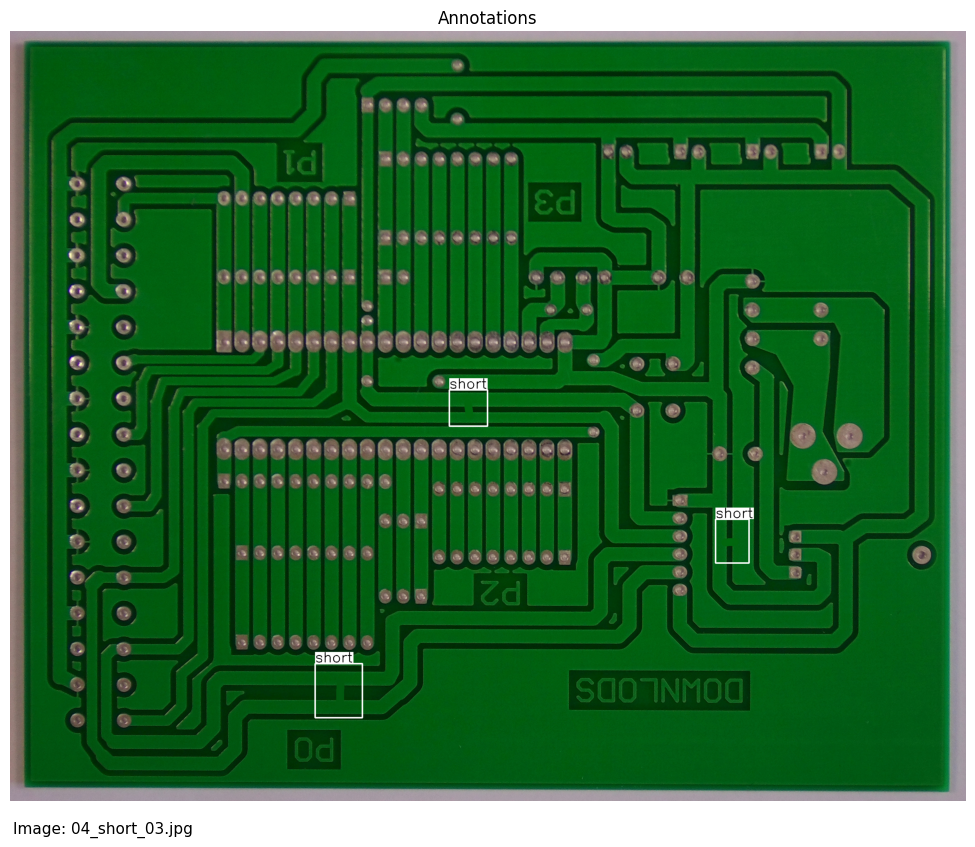

In [ ]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_missing_hole_07.jpg    640     640  missing_hole   366   137   378   158
1  01_missing_hole_07.jpg    640     640  missing_hole   293   420   310   452
2  01_missing_hole_07.jpg    640     640  missing_hole   544    96   558   118
3  01_missing_hole_03.jpg    640     640  missing_hole   559   196   569   214
4  01_missing_hole_03.jpg    640     640  missing_hole   283   302   293   321

# Split dataset

In [ ]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [ ]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.80, val_split=0.50):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# K-Fold Cross Validation

In [ ]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [ ]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

0    1    2    3    4    5
01_missing_hole_01  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_02  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_03  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_04  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_05  4.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

0         1         2         3         4         5
split_1  0.388316     0.644  0.457831  0.518797  0.458955  0.531496
split_2  0.690377  0.334416    0.5125  0.412587  0.582996     0.556
split_3  0.453237  0.556818  0.531646  0.578125  0.464419  0.419708

In [ ]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [ ]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Model Training

In [ ]:
model = YOLO('yolov8s.pt')
results = {}

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 25
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup)
    results[k] = model.metrics  # save output metrics for further analysis

100%|██████████| 21.5M/21.5M [00:00<00:00, 341MB/s]


Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 291MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels... 369 images, 0 backgrounds, 0 corrupt: 100%|██████████| 369/369 [00:04<00:00, 86.53it/s] 


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels... 185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 185/185 [00:05<00:00, 35.39it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels.cache
Plotting labels to pcb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.07G      3.675      21.42      1.939          0        640: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]

                   all        185        784   0.000241     0.0364   0.000145   7.81e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       3.9G       3.19      5.719      1.435          4        640: 100%|██████████| 24/24 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        185        784      0.992     0.0556      0.101     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.96G      2.957      3.836      1.289         13        640: 100%|██████████| 24/24 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


                   all        185        784       0.27      0.279      0.205     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.09G      2.794      3.191       1.25         15        640: 100%|██████████| 24/24 [00:11<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        185        784       0.44      0.345      0.326      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.92G      2.568      2.868      1.164         10        640: 100%|██████████| 24/24 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

                   all        185        784      0.412      0.438      0.401      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       4.1G      2.439      2.529      1.143         11        640: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        185        784      0.498      0.507      0.487       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.95G      2.407      2.308      1.117         11        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

                   all        185        784      0.737      0.442      0.539      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.11G       2.35      2.153      1.135          3        640: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        185        784      0.736      0.627      0.664       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.08G      2.286      2.037      1.092          8        640: 100%|██████████| 24/24 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]

                   all        185        784      0.787      0.599      0.674      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.11G      2.305      2.059      1.096          1        640: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        185        784      0.783      0.631      0.694      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.93G      2.194      1.838      1.084         10        640: 100%|██████████| 24/24 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all        185        784      0.815      0.667      0.736      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.04G      2.101      1.688      1.063          3        640: 100%|██████████| 24/24 [00:09<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        185        784      0.877      0.668      0.752      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.06G       2.09      1.682      1.046          4        640: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        185        784      0.878      0.731      0.794      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.07G      2.158      1.701      1.052          2        640: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.08it/s]

                   all        185        784      0.862      0.732      0.793      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.1G      2.093      1.605      1.039         17        640: 100%|██████████| 24/24 [00:12<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        185        784        0.9      0.704       0.79      0.344


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.06G      1.803      1.166      1.015          2        640: 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        185        784      0.937      0.699      0.811      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25       3.9G      1.893      1.177       1.02          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

                   all        185        784      0.925      0.719      0.814      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.06G       1.76      1.054     0.9946          5        640: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

                   all        185        784      0.909      0.764      0.839      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.91G      1.762      1.001     0.9773          5        640: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        185        784      0.896      0.793      0.834      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.05G      1.752          1     0.9808          4        640: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        185        784      0.918      0.817      0.863      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.06G      1.683     0.9339     0.9749          3        640: 100%|██████████| 24/24 [00:09<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        185        784      0.921      0.805      0.867      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.9G      1.699     0.9524     0.9824          5        640: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]

                   all        185        784       0.93      0.816      0.869        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.05G      1.725     0.9297      0.982          3        640: 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]

                   all        185        784      0.937      0.797      0.866      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.9G      1.631     0.9028     0.9746          5        640: 100%|██████████| 24/24 [00:11<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        185        784      0.925      0.831      0.877       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.06G      1.709     0.9231     0.9788          6        640: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        185        784      0.926      0.831       0.88      0.413



25 epochs completed in 0.117 hours.
Optimizer stripped from pcb/train/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train/weights/best.pt, 22.5MB

Validating pcb/train/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


                   all        185        784      0.925      0.831       0.88      0.414
          missing_hole         27        113      0.986      0.991      0.995      0.552
            mouse_bite         39        161      0.943      0.745      0.824      0.358
          open_circuit         26        114      0.921      0.868      0.905      0.394
                 short         32        138      0.875      0.906      0.916      0.385
                  spur         30        123      0.898      0.626      0.713      0.334
       spurious_copper         31        135      0.926      0.852      0.925      0.459
Speed: 0.9ms preprocess, 4.4ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to pcb/train
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/split_2_dataset.yaml, epochs=25, time=None, patience=100,

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels... 369 images, 0 backgrounds, 0 corrupt: 100%|██████████| 369/369 [00:05<00:00, 68.31it/s] 


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels... 185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 185/185 [00:03<00:00, 51.02it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels.cache
Plotting labels to pcb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.33G      2.043       1.58      1.028          1        640: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all        185        792       0.97      0.828      0.915      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.93G      2.098      1.627      1.028          3        640: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all        185        792      0.941      0.827      0.902       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.14G      2.104      1.618      1.037         11        640: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

                   all        185        792      0.863        0.8      0.848      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.09G      2.169      1.718      1.083         14        640: 100%|██████████| 24/24 [00:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        185        792      0.913       0.75      0.838      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.91G      2.191      1.766      1.062          8        640: 100%|██████████| 24/24 [00:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.05it/s]

                   all        185        792      0.886       0.78      0.844      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.09G      2.092      1.643      1.042         15        640: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]

                   all        185        792      0.909      0.799      0.858       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.08G      2.111      1.589      1.022          7        640: 100%|██████████| 24/24 [00:13<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

                   all        185        792      0.905      0.835      0.873      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.11G      2.017      1.584      1.032          3        640: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all        185        792      0.903      0.791      0.864       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.11G      2.109      1.532      1.032          8        640: 100%|██████████| 24/24 [00:09<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all        185        792      0.913      0.804      0.893      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      3.95G      1.949      1.563     0.9877          0        640: 100%|██████████| 24/24 [00:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

                   all        185        792      0.921      0.826      0.893      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.09G      2.006      1.497      1.041          8        640: 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        185        792      0.901      0.837      0.893      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.05G      1.932      1.368      1.001          4        640: 100%|██████████| 24/24 [00:13<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

                   all        185        792      0.913      0.843      0.899      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      3.87G      1.927      1.344     0.9975          5        640: 100%|██████████| 24/24 [00:11<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        185        792      0.909       0.84      0.902      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.92G      1.981      1.414     0.9874          1        640: 100%|██████████| 24/24 [00:09<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        185        792      0.909      0.834      0.906      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      3.95G      1.966      1.376     0.9948         12        640: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

                   all        185        792      0.911      0.819      0.898      0.429


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       3.9G      1.703     0.9933     0.9923          3        640: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        185        792      0.934      0.826      0.898      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.06G      1.708     0.9595     0.9826          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all        185        792      0.923      0.852      0.896      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25       3.9G       1.66     0.8838     0.9725          5        640: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

                   all        185        792      0.921      0.859      0.894       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25       3.9G      1.698     0.8844     0.9548          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        185        792      0.938      0.877      0.918      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.06G      1.615     0.8401     0.9426          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all        185        792      0.921      0.878      0.917      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25       3.9G      1.571     0.7881     0.9497          3        640: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        185        792      0.935      0.886      0.922      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25       3.9G      1.647     0.8449     0.9393          5        640: 100%|██████████| 24/24 [00:09<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

                   all        185        792      0.941      0.895      0.925      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.06G      1.573     0.7991     0.9283          3        640: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]

                   all        185        792      0.949      0.882      0.925      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25       3.9G      1.537     0.7857     0.9445          5        640: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        185        792      0.951      0.889      0.927      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25       3.9G       1.61     0.8406     0.9329          5        640: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        185        792      0.943        0.9      0.929      0.473



25 epochs completed in 0.117 hours.
Optimizer stripped from pcb/train2/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train2/weights/best.pt, 22.5MB

Validating pcb/train2/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


                   all        185        792      0.949      0.895      0.926      0.474
          missing_hole         39        165      0.992      0.976      0.989      0.619
            mouse_bite         26        103      0.936      0.848      0.881      0.408
          open_circuit         29        123          1       0.83       0.92      0.403
                 short         27        118      0.943       0.98      0.985      0.535
                  spur         33        144      0.959      0.812      0.867      0.419
       spurious_copper         31        139      0.862      0.921      0.917      0.457
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 10.7ms postprocess per image
Results saved to pcb/train2
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/split_3_dataset.yaml, epochs=25, time=None, patience=10

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels... 370 images, 0 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:05<00:00, 71.87it/s] 


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:05<00:00, 35.30it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels.cache
Plotting labels to pcb/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train22
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.32G      1.889      1.327     0.9778         12        640: 100%|██████████| 24/24 [00:15<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

                   all        184        786      0.974      0.934      0.972      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.97G      1.902      1.324     0.9929         11        640: 100%|██████████| 24/24 [00:15<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        184        786      0.945      0.908      0.955      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.01G      1.921      1.322     0.9833         11        640: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        184        786      0.949      0.875      0.948      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.97G       1.99      1.456      1.011         25        640: 100%|██████████| 24/24 [00:10<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all        184        786       0.94      0.899       0.95      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      3.94G      2.018      1.424      0.999          8        640: 100%|██████████| 24/24 [00:11<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

                   all        184        786      0.909      0.873      0.927      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.09G      1.972      1.418      1.004         14        640: 100%|██████████| 24/24 [00:14<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        184        786      0.914      0.862      0.923      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      3.97G      1.946      1.356      1.013          4        640: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        184        786      0.936      0.882      0.933      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      3.94G      1.954      1.368     0.9976          9        640: 100%|██████████| 24/24 [00:10<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        184        786      0.938      0.886      0.933      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      3.89G       1.87      1.331     0.9771          7        640: 100%|██████████| 24/24 [00:11<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.03it/s]

                   all        184        786      0.953      0.873      0.936      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.26G      1.899      1.335     0.9878          9        640: 100%|██████████| 24/24 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

                   all        184        786      0.945      0.887      0.942      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      3.97G      1.857      1.337     0.9774         11        640: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

                   all        184        786      0.953      0.879      0.937      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      3.89G       1.84      1.208     0.9628         23        640: 100%|██████████| 24/24 [00:10<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all        184        786      0.954      0.887      0.954      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.06G      1.878      1.258     0.9788          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]

                   all        184        786      0.953      0.886       0.95      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      3.97G      1.872      1.243      0.955         16        640: 100%|██████████| 24/24 [00:14<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

                   all        184        786      0.948      0.892      0.949      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.05G      1.871      1.242     0.9506         34        640: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all        184        786      0.952      0.907      0.958      0.492


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      3.92G      1.633     0.8904     0.9518          6        640: 100%|██████████| 24/24 [00:11<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all        184        786      0.956      0.889      0.948      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      3.92G      1.633     0.8598     0.9476          6        640: 100%|██████████| 24/24 [00:09<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

                   all        184        786       0.95      0.904       0.95      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.92G       1.58      0.824      0.937         10        640: 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        184        786      0.951      0.903       0.95      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      3.92G      1.546      0.809     0.9421         10        640: 100%|██████████| 24/24 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        184        786      0.954      0.916       0.96      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.07G      1.607     0.8623     0.9411          5        640: 100%|██████████| 24/24 [00:10<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        184        786      0.953      0.915      0.964      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.08G      1.478     0.7602     0.9161          7        640: 100%|██████████| 24/24 [00:11<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]

                   all        184        786      0.963      0.906       0.96       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      3.92G      1.496     0.7371     0.9238         10        640: 100%|██████████| 24/24 [00:08<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all        184        786      0.959      0.921      0.964      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      3.92G      1.474     0.7381     0.9128          7        640: 100%|██████████| 24/24 [00:10<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]

                   all        184        786      0.957      0.911      0.963      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      3.92G      1.511     0.7294     0.9141         10        640: 100%|██████████| 24/24 [00:11<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

                   all        184        786      0.961      0.911      0.965      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      3.92G       1.48     0.7421     0.9156          8        640: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

                   all        184        786      0.962      0.908      0.964      0.511



25 epochs completed in 0.122 hours.
Optimizer stripped from pcb/train22/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train22/weights/best.pt, 22.5MB

Validating pcb/train22/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


                   all        184        786      0.976      0.935      0.972      0.535
          missing_hole         28        126      0.993          1      0.995      0.605
            mouse_bite         32        147      0.993       0.96      0.993       0.56
          open_circuit         31        126      0.984      0.881      0.967      0.466
                 short         37        148      0.986      0.971      0.982      0.536
                  spur         29        124      0.991      0.893      0.947      0.516
       spurious_copper         27        115      0.906      0.904      0.948      0.529
Speed: 0.3ms preprocess, 5.3ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to pcb/train22


In [ ]:
results_dir = '/content/pcb/train22'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'/content/drive/MyDrive/PCB_DATASET/results'

In [ ]:
from google.colab import drive
import pickle
import os

# Mount Google Drive to access the folders
# Path to the folder in your Google Drive where you want to save the model
pkl_file_path = '/content/drive/MyDrive/PCB_DATASET/model_weights.pkl'  # Change this to your desired path

# Get the best model after training
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)  # Load the model

# Extract the model's state_dict (weights)
model_weights = model.model.state_dict()

# Create directory in Google Drive if it doesn't exist
os.makedirs(os.path.dirname(pkl_file_path), exist_ok=True)

# Save the model weights as a .pkl file in Google Drive
with open(pkl_file_path, 'wb') as f:
    pickle.dump(model_weights, f)

print(f"Model weights saved as a .pkl file at {pkl_file_path}")


# Model

In [ ]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   23.9469         1.88927         1.32663         0.97779   
1      2   54.2380         1.90219         1.32428         0.99289   
2      3   71.5559         1.92094         1.32157         0.98330   
3      4   88.1290         1.98956         1.45582         1.01108   
4      5  103.7030         2.01772         1.42413         0.99900   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.97353            0.93364           0.97177   
1               0.94499            0.90815           0.95474   
2               0.94933            0.87549           0.94850   
3               0.94010            0.89858           0.94985   
4               0.90936            0.87323           0.92724   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.53479       1.49047       0.75861       0.90404  0.000230   
1              0.46618       1.66578       0.84946       0.93175  0.000451   
2              0.46354       1.67641       0.85943       0.93480  0.000653   
3              0.47281       1.67061       0.86473       0.94043  0.000836   
4              0.44932       1.73876       0.94221       0.95681  0.000840   

     lr/pg1    lr/pg2  
0  0.000230  0.000230  
1  0.000451  0.000451  
2  0.000653  0.000653  
3  0.000836  0.000836  
4  0.000840  0.000840

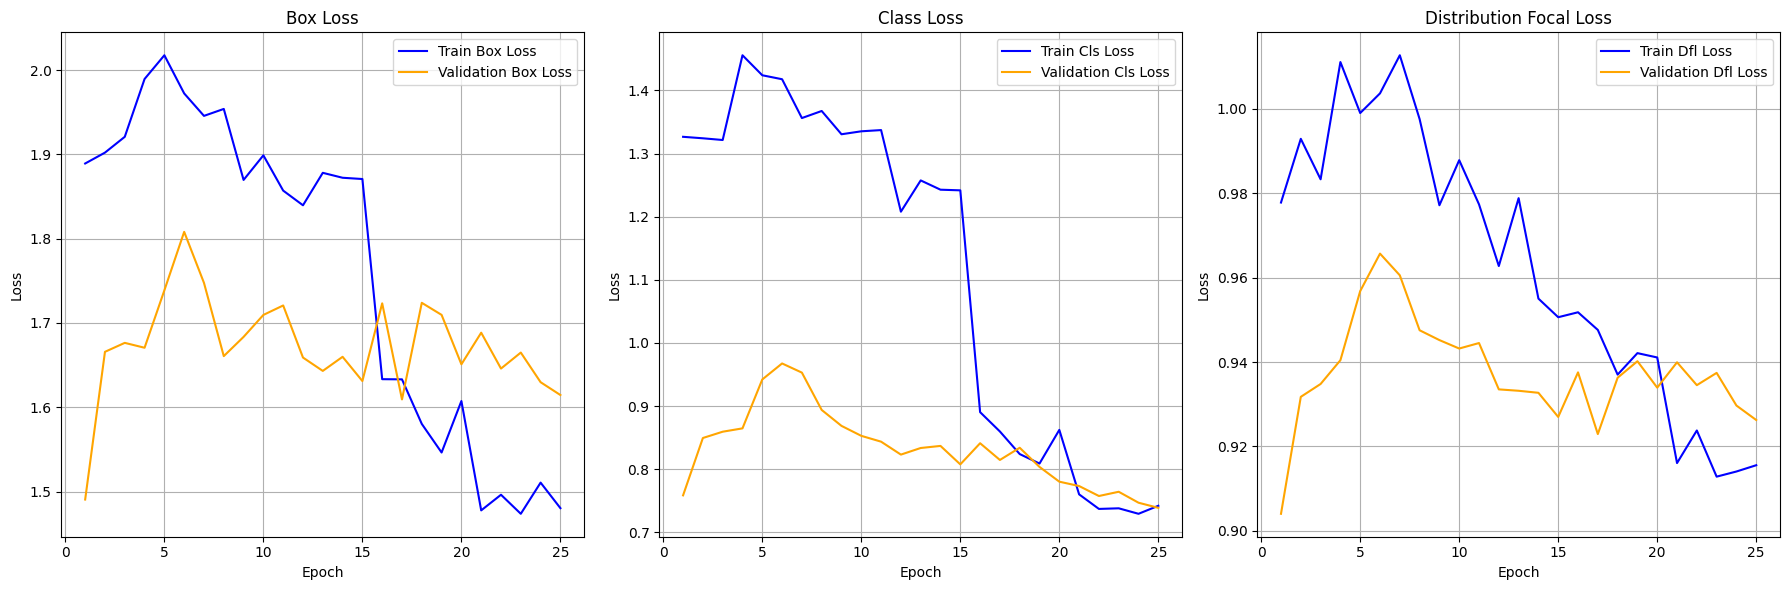

In [ ]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predict on test data

In [ ]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_20.jpg: 640x640 3 missing_holes, 16.3ms
image 2/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_mouse_bite_05.jpg: 640x640 1 mouse_bite, 21.2ms
image 3/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_mouse_bite_15.jpg: 640x640 (no detections), 16.4ms
image 4/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_02.jpg: 640x640 2 open_circuits, 16.3ms
image 5/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_05.jpg: 640x640 2 open_circuits, 16.3ms
image 6/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_08.jpg: 640x640 1 mouse_bite, 2 open_circuits, 16.3ms
image 7/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_11.jpg: 640x640 1 open_circuit, 16.2ms
image 8/139 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_14.jpg: 640x640 3 open_circuits, 16.2ms
image 9/139 /content/driv

In [ ]:
predict_dir = '/content/runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'/content/drive/MyDrive/PCB_DATASET/results/predict'

In [ ]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [ ]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels
print(dest_predict_dir)
# file_path = os.path.join(dest_predict_dir, '/04_mouse_bite_05.jpg')
file_path = "/content/drive/MyDrive/PCB_DATASET/results/predict/labels/01_missing_hole_20.txt"
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

/content/drive/MyDrive/PCB_DATASET/results/predict


[[0.0, 0.0835298, 0.380508, 0.0182491, 0.0335846, 0.705014],
 [0.0, 0.842869, 0.16364, 0.0198503, 0.0372977, 0.678772],
 [0.0, 0.878893, 0.712692, 0.022872, 0.0353596, 0.666613]]

In [ ]:
annot_df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_missing_hole_07.jpg   3034    1586  missing_hole  1737   340  1793   394
1  01_missing_hole_07.jpg   3034    1586  missing_hole  1390  1042  1470  1122
2  01_missing_hole_07.jpg   3034    1586  missing_hole  2580   238  2648   294
3  01_missing_hole_03.jpg   3034    1586  missing_hole  2651   487  2700   531
4  01_missing_hole_03.jpg   3034    1586  missing_hole  1342   749  1393   796

In [ ]:
pred_annot_df = yolo_to_original_annot('01_missing_hole_20.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

filename  width  height         class  xmin  ymin  xmax  \
0  01_missing_hole_20.jpg   3034    1586  missing_hole   225   576   281   
1  01_missing_hole_20.jpg   3034    1586  missing_hole  2527   229  2587   
2  01_missing_hole_20.jpg   3034    1586  missing_hole  2631  1102  2701   

   ymax  confidence  
0   630    0.705014  
1   289    0.678772  
2  1158    0.666613

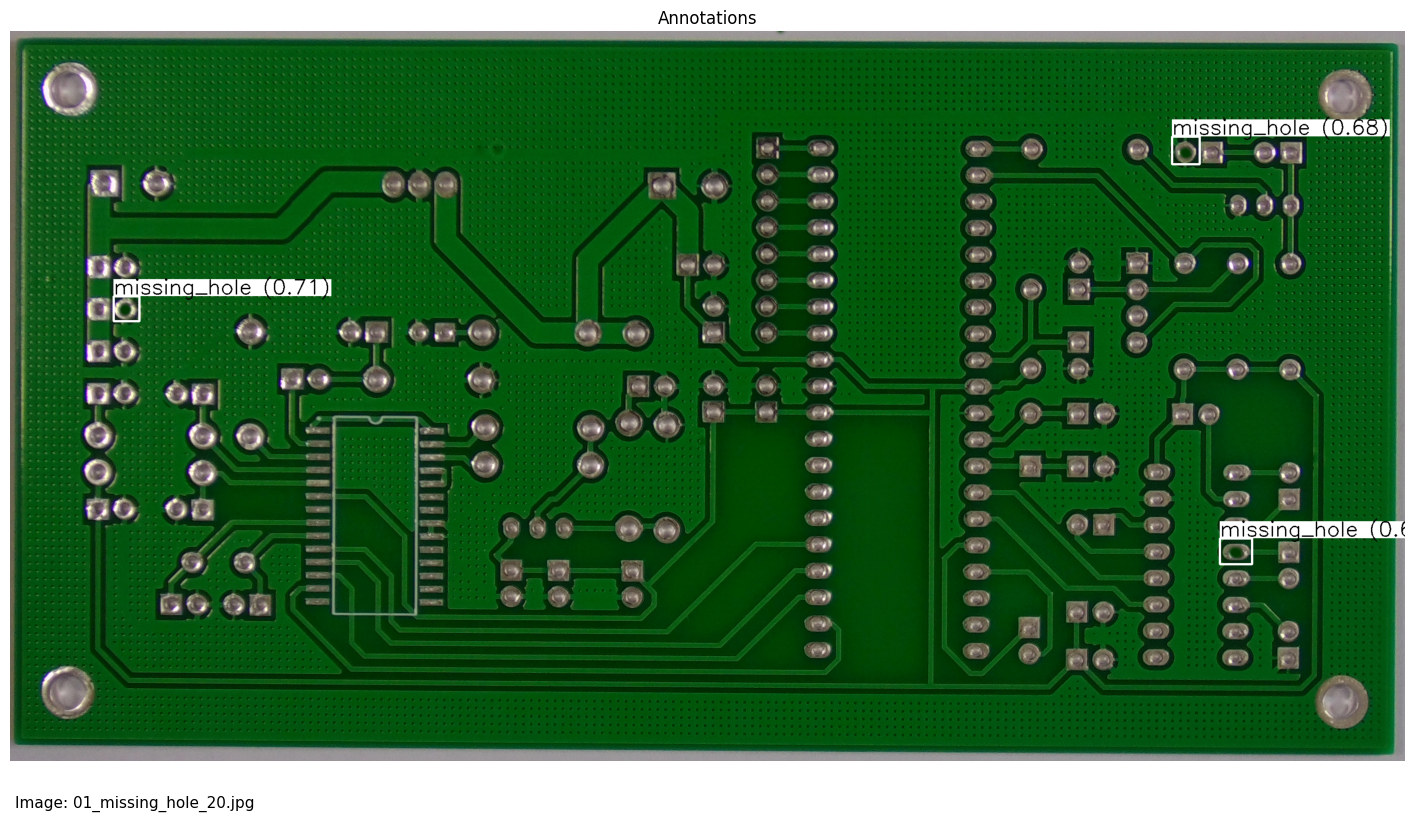

In [ ]:
visualize_annotations('01_missing_hole_20.jpg', images_dir, pred_annot_df, is_subfolder=True);

In [ ]:
model.export()

In [ ]:
custom_img_dir = os.path.join(root_dir, 'custom_images')
resized_custom_img_dir = os.path.join(custom_img_dir, 'resized')
resize_images(custom_img_dir, resized_custom_img_dir)

In [ ]:
# prompt: make confusiyon metrix for the model

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
# Replace these with your actual true and predicted labels
# y_true = [...]  # True labels for your test data
# y_pred = [...]  # Predicted labels from your model

# Calculate the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix using seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#             xticklabels=classes, yticklabels=classes) # Assuming 'classes' is defined
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
model.val()

Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels.cache... 184 images, 0 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


                   all        184        786      0.978      0.935      0.972      0.535
          missing_hole         28        126      0.993          1      0.995      0.609
            mouse_bite         32        147      0.993      0.961      0.993      0.558
          open_circuit         31        126      0.984      0.881      0.967      0.466
                 short         37        148      0.986      0.971      0.982      0.534
                  spur         29        124      0.991      0.893      0.947      0.516
       spurious_copper         27        115      0.922      0.904      0.949      0.526
Speed: 0.4ms preprocess, 9.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/val4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb7d33b4eb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [ ]:

# Define paths to the actual and predicted folders in your Google Drive
actual_folder = '/content/drive/MyDrive/PCB_DATASET/output/labels/val'
predicted_folder = '/content/drive/MyDrive/PCB_DATASET/results/predict/labels'



In [ ]:
# List all txt files in both directories
actual_files = [f for f in os.listdir(actual_folder) if f.endswith('.txt')]
predicted_files = [f for f in os.listdir(predicted_folder) if f.endswith('.txt')]

# Initialize lists to store the first numbers (class labels) from each file
actual_labels = []
predicted_labels = []

# Compare files with the same name in both folders
for actual_file in actual_files:
    # Check if the file also exists in the predicted folder
    if actual_file in predicted_files:
        # Read all lines from the actual label file
        with open(os.path.join(actual_folder, actual_file), 'r') as f:
            actual_lines = f.readlines()  # Read all lines

        # Read all lines from the predicted label file
        with open(os.path.join(predicted_folder, actual_file), 'r') as f:
            predicted_lines = f.readlines()  # Read all lines

        # Compare line by line
        if len(actual_lines) != len(predicted_lines):
            print(f"Warning: File {actual_file} has a different number of lines between the two folders.")
        else:
            for line_idx, (actual_line, predicted_line) in enumerate(zip(actual_lines, predicted_lines)):
                # Extract the first number (class label) from the first line of each
                actual_class = int(actual_line.split()[0])  # Get the first number (class) in the line
                predicted_class = int(predicted_line.split()[0])  # Get the first number (class) in the line

                # Compare the values
                if actual_class == predicted_class:
                    print(f"Match: {actual_file} - Line {line_idx + 1}: Actual: {actual_class}, Predicted: {predicted_class}")
                else:
                    print(f"Mismatch: {actual_file} - Line {line_idx + 1}: Actual: {actual_class}, Predicted: {predicted_class}")
    else:
        print(f"Warning: File {actual_file} not found in predicted_labels folder.")

Match: 05_open_circuit_03.txt - Line 1: Actual: 2, Predicted: 2
Match: 05_open_circuit_03.txt - Line 2: Actual: 2, Predicted: 2
Match: 05_open_circuit_03.txt - Line 3: Actual: 2, Predicted: 2
Match: 04_open_circuit_11.txt - Line 1: Actual: 2, Predicted: 2
Match: 04_open_circuit_11.txt - Line 2: Actual: 2, Predicted: 2
Match: 04_open_circuit_11.txt - Line 3: Actual: 2, Predicted: 2
Match: 11_missing_hole_07.txt - Line 1: Actual: 0, Predicted: 0
Match: 11_missing_hole_07.txt - Line 2: Actual: 0, Predicted: 0
Match: 11_missing_hole_07.txt - Line 3: Actual: 0, Predicted: 0
Match: 11_missing_hole_07.txt - Line 4: Actual: 0, Predicted: 0
Match: 11_missing_hole_07.txt - Line 5: Actual: 0, Predicted: 0
Match: 01_missing_hole_20.txt - Line 1: Actual: 0, Predicted: 0
Match: 01_missing_hole_20.txt - Line 2: Actual: 0, Predicted: 0
Match: 01_missing_hole_20.txt - Line 3: Actual: 0, Predicted: 0
Match: 11_open_circuit_05.txt - Line 1: Actual: 2, Predicted: 2
Match: 11_open_circuit_05.txt - Line 2: 

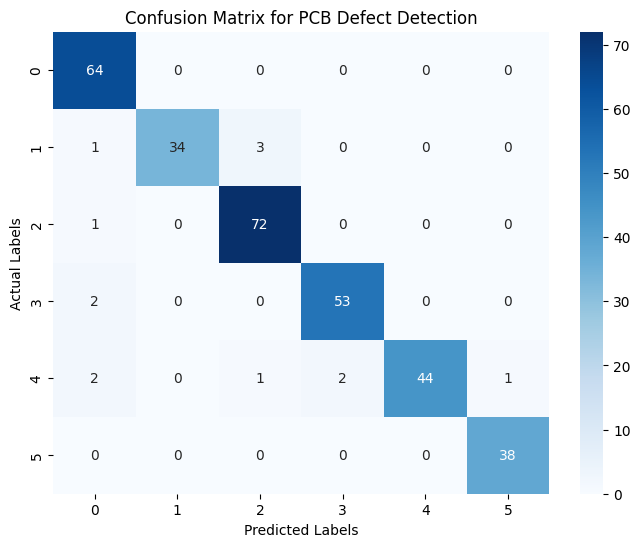

Accuracy: 95.91%


In [ ]:
from google.colab import drive
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




# Convert lists to numpy arrays for confusion matrix
actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.title('Confusion Matrix for PCB Defect Detection')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Calculate classification metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")

